# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black;"><strong>Module importations</strong></span>

In [1]:
import scipy.io
import os
import h5py
import numpy as np
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt
# from scipy.stats import sem
from scipy.stats import wilcoxon
import pandas as pd
import json
import jdata as jd

In [2]:
# qt for popup window (savable as pdf, svg...), inline for inline plot, notebook for interactive plot, widget for interactive plot
%matplotlib widget 
plt.ioff()

# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>FUNCTIONS</strong></span>

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>find_keys_for_value(data, target_value)</strong></span>

In [3]:
def find_keys(x,y):
    keys = []
    for ext_keys in x.keys():
        for int_keys in x[ext_keys].keys():
            for i in range(len(x[ext_keys][int_keys])):
                if (y.shape == x[ext_keys][int_keys][i].shape) and (np.array([np.array_equal(y[n], x[ext_keys][int_keys][i][n]) for n in range(len(y))])).all():
                    keys.append([ext_keys,int_keys,i])
    return keys[0]

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>filepath(path, file)</strong></span>

In [4]:
def filepath(path, file):
    return os.path.join(path, file) 

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>plots(row_number, col_number, width, height, *args, suptitle=None,**kwargs)</strong></span>

In [5]:
def plots(row_number, col_number, *args, suptitle=None, supxlabel=None, supylabel=None, save=False, filename='Several_plots.png', **kwargs):
    if len(args) != row_number * col_number:
        raise ValueError("Le nombre d'arguments fournis ne correspond pas au nombre de sous-graphiques attendus.")
    
    fig, axs = plt.subplots(row_number, col_number)#, figsize=(width, height))
    
    # Flatten axes if there's only one row or one column
    if row_number == 1 or col_number == 1:
        axs = axs.reshape(-1)
    
    for i, plot_call in enumerate(args):
        if row_number > 1 and col_number > 1:  # If there's more than one row and more than one column
            col = i // row_number
            row = i % row_number
            ax = axs[row, col]
        else:  # If there's only one row or one column
            ax = axs[i]
        plot_call(ax)

    for ax in axs.flat:
        ax.set(**kwargs)

    
    plt.suptitle(suptitle)
    fig.supxlabel(supxlabel)
    fig.supylabel(supylabel)
    
    # plt.tight_layout()
    # fig.set_tight_layout(True)

    if save:
        plt.savefig(filename, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>plotVelocity(velocity)</strong></span>

In [6]:
def plotVelocity(velocity, color='c', ax='', xlabel=True, ylabel=True, save=False, filename='velocity.png'):
    if ax:
        ax.plot(duration, velocity, color=color, linewidth='1')
        ax.set_ylim(-rotationSpeed, rotationSpeed)
        ax.set_xlim(-timeBef, timeAft)
        if ylabel:
            ax.set_ylabel(r'Mean Velocity $(^\circ/s)$')
        if xlabel:
            ax.set_xlabel(r'Time $(s)$')
        ax.set_yticks([-rotationSpeed, 0, rotationSpeed])
    else:
        plt.plot(duration, velocity, color=color, linewidth='1')
        plt.ylim(-rotationSpeed, rotationSpeed)
        plt.xlim(-timeBef, timeAft)
        if ylabel:
            plt.ylabel(r'Mean Velocity $(^\circ/s)$')
        if xlabel:
            plt.xlabel(r'Time $(s)$')
        plt.yticks([-rotationSpeed, 0, rotationSpeed])

        if save:
            plt.savefig(filename, bbox_inches='tight')
            plt.close()
        else:
            plt.show()

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>plotRaster(spikeTimesObject)</strong></span>

In [7]:
def plotRaster(spikeTimesObject, color='black', ax='', xlabel='Time (s)', ylabel='# Trial', extra=None, title='', plotvelocity=False, velocitycolor='k', velocityalpha=0.13, save=False, filename='Raster.png'):

    linelengths = 1

    if ax:
        # for trial_id, spike_times in enumerate(spikeTimesObject):
        #     ax.eventplot(spike_times, lineoffsets=trial_id+1, linelengths=linelengths, color=color)

        ax.eventplot(spikeTimesObject, linelengths=linelengths, colors=color)

        if ylabel:
            ax.set_ylabel(ylabel)
        if xlabel:
            ax.set_xlabel(xlabel)
            
        ax.set_title('')
        ax.set_xlim(-timeBef,timeAft)
        
        ### annulate the offset due to python indexation
        def custom_formatter(x, pos):
            return f"{int(x) + 1}"
        ax.yaxis.set_major_formatter(plt.FuncFormatter(custom_formatter))

        ax.set_ylim(0-linelengths/2,len(spikeTimesObject)-1+linelengths/2)


        if plotvelocity:
            keys = find_keys(SpikeTimes, spikeTimesObject)
            condition = keys[0]
            direction = keys[1]
            normalization = 1/rotationSpeed*len(spikeTimesObject)
            rotation = MeanRotation[condition][direction]
            
            if min(rotation) < -10:
                rotation = rotation * normalization - min(rotation * normalization) - linelengths/2
                haxis = len(spikeTimesObject)*np.ones(len(duration))
            else:
                rotation = rotation * normalization - linelengths/2
                haxis = np.zeros(len(duration)) - linelengths/2
            ax.plot(duration, rotation, color=velocitycolor, linewidth='1', alpha=velocityalpha)
            ax.fill_between(duration, rotation, haxis, color=velocitycolor, alpha=velocityalpha*0.8)


        if extra is not None:
            extra()
        
        ax.set_title(title)
            
    else:
        # for trial_id, spike_times in enumerate(spikeTimesObject):
        #     plt.eventplot(spike_times, lineoffsets=trial_id+1, linelengths=linelengths, color=color)

        plt.eventplot(spikeTimesObject, linelengths=linelengths, colors=color)


        if extra is not None:
            extra()
        
        if ylabel:
            plt.ylabel(ylabel)
        if xlabel:
            plt.xlabel(xlabel)
        
        plt.title('')
        plt.xlim(-timeBef,timeAft)
        

        ### annulate the offset due to python indexation
        def custom_formatter(x, pos):
            return f"{int(x) + 1}"
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(custom_formatter))

        plt.ylim(0-linelengths/2,len(spikeTimesObject)-1+linelengths/2)

        if plotvelocity:
            keys = find_keys(SpikeTimes, spikeTimesObject)
            condition = keys[0]
            direction = keys[1]
            normalization = 1/rotationSpeed*len(spikeTimesObject)
            rotation = MeanRotation[condition][direction]
            
            if min(rotation) < -rotationSpeed/2:
                rotation = rotation * normalization - min(rotation * normalization) - linelengths/2
                haxis = len(spikeTimesObject)*np.ones(len(duration))
            else:
                rotation = rotation * normalization - linelengths/2
                haxis = np.zeros(len(duration)) - linelengths/2
            plt.plot(duration, rotation, color=velocitycolor, alpha=velocityalpha)
            plt.fill_between(duration, rotation, haxis, color=velocitycolor, alpha=velocityalpha*0.8)

        plt.title(title)

        if save:
            plt.savefig(filename, bbox_inches='tight')
            plt.close()
        else:
            plt.show()

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>plotPSTH(StudiedSpikeTimes)</strong></span>

In [8]:
def plotPSTH(StudiedSpikeTimes,color='k',shadedcolor='c',binResolution = 0.03,ax='',xlabel=True,ylabel=True, save=False, filename='PSTH.png'):
    if ax:
        local_trial_number = len(StudiedSpikeTimes)

        spike_number_per_trial = [[] for _ in range(local_trial_number)]
        edges = []
        unitary_firing_rate = [[] for _ in range(local_trial_number)]

        for trial in range(local_trial_number):
            spike_number_per_trial[trial], edges = np.histogram(StudiedSpikeTimes[trial], bins=np.arange(-timeBef, timeAft + binResolution, binResolution))

        frequency_per_trial = [[spike_number_per_trial[trial][bin]/binResolution for bin in range(len(edges)-1)] for trial in range(local_trial_number)]
        mean_frequency = [np.mean([frequency_per_trial[trial][bin] for trial in range(local_trial_number)]) for bin in range(len(edges)-1)]

        Zscore = (mean_frequency - np.mean(mean_frequency)) / np.std(mean_frequency) if np.std(mean_frequency) != 0 else np.zeros(len(mean_frequency))
        Zunitary = (frequency_per_trial - np.mean(mean_frequency)) / np.std(mean_frequency) if np.std(mean_frequency) != 0 else np.zeros(len(frequency_per_trial))
        SEM = np.std(Zunitary)/np.sqrt(len(Zunitary)) if np.std(mean_frequency) != 0 else np.zeros(len(mean_frequency))


        # plt.figure(figsize=(15,6))
        ax.plot(edges[:-1], Zscore, color=color)
        ax.fill_between(edges[:-1], Zscore-SEM, Zscore+SEM, alpha=0.1, color=shadedcolor)
        ax.set_xlim(-timeBef,timeAft)
        if ylabel:
            ax.set_ylabel('Z-Score FR')
        if xlabel:
            ax.set_xlabel('Time (s)')
    else:
        local_trial_number = len(StudiedSpikeTimes)

        spike_number_per_trial = [[] for _ in range(local_trial_number)]
        edges = []
        unitary_firing_rate = [[] for _ in range(local_trial_number)]

        for trial in range(local_trial_number):
            spike_number_per_trial[trial], edges = np.histogram(StudiedSpikeTimes[trial], bins=np.arange(-timeBef, timeAft + binResolution, binResolution))

        frequency_per_trial = [[spike_number_per_trial[trial][bin]/binResolution for bin in range(len(edges)-1)] for trial in range(local_trial_number)]
        mean_frequency = [np.mean([frequency_per_trial[trial][bin] for trial in range(local_trial_number)]) for bin in range(len(edges)-1)]

        Zscore = (mean_frequency - np.mean(mean_frequency)) / np.std(mean_frequency) if np.std(mean_frequency) != 0 else np.zeros(len(mean_frequency))
        Zunitary = (frequency_per_trial - np.mean(mean_frequency)) / np.std(mean_frequency) if np.std(mean_frequency) != 0 else np.zeros(len(frequency_per_trial))
        SEM = np.std(Zunitary)/np.sqrt(len(Zunitary)) if np.std(mean_frequency) != 0 else np.zeros(len(mean_frequency))


        # plt.figure(figsize=(15,6))
        plt.plot(edges[:-1], Zscore, color=color)
        plt.fill_between(edges[:-1], Zscore-SEM, Zscore+SEM, alpha=0.1, color=shadedcolor)
        plt.xlim(-timeBef,timeAft)
        if ylabel:
            plt.ylabel('Z-Score FR')
        if xlabel:
            plt.xlabel('Time (s)')

        if save:
            plt.savefig(filename, bbox_inches='tight')
            plt.close()
        else:
            plt.show()

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>figure1(unit)</strong></span>

In [9]:
def figure1(unit,firstcolor='c',secondcolor='k',binResolution=0.03,suptitle='Figure 1 unit', save=False, filename='figure 1.png'):
      plots(3, 2,
            lambda ax: plotVelocity(MeanRotation['first']['CW'],color=firstcolor, ax=ax, xlabel=False),
            lambda ax: plotRaster(SpikeTimes['first']['CW'][unit], color=firstcolor, ax=ax, xlabel=False),
            lambda ax: plotPSTH(SpikeTimes['first']['CW'][unit],color=firstcolor, shadedcolor=firstcolor, ax=ax),
            lambda ax: plotVelocity(MeanRotation['second']['CCW'],color=secondcolor,ax=ax,ylabel=False,xlabel=False),
            lambda ax: plotRaster(SpikeTimes['second']['CCW'][unit], color=secondcolor, ax=ax,xlabel=False,ylabel=False),
            lambda ax: plotPSTH(SpikeTimes['second']['CCW'][unit],color=secondcolor, shadedcolor=secondcolor, ax=ax,ylabel=False),
            suptitle=suptitle,
            save=save,
            filename=filename
      )

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>seeModulation(condition, modulated)</strong></span>

In [10]:
def seeModulation(condition,modulated, color='k', velocitycolor='k', velocityalpha=0.13, save=False, filename='Modulation'):
      position = np.where([(modulation[condition][neuron]['selectivity']==modulated.split()[0]) and (modulation[condition][neuron]['type']==modulated.split()[1]) for neuron in range(Nclust)])[0]
      print(f'The {modulated} modulated neurons are {position}')

      by = modulated.split()[0]
      how = modulated.split()[1]

      for unit in np.where([modulation[condition][neuron]['selectivity']==by and modulation[condition][neuron]['type']==how for neuron in range(Nclust)])[0]:
            plots(2,1,
                  lambda ax: plotRaster(SpikeTimes[condition]['CW'][unit], color=color, ax=ax, xlabel=False, ylabel=False, plotvelocity=True, velocitycolor=velocitycolor, velocityalpha=velocityalpha),
                  lambda ax: plotRaster(SpikeTimes[condition]['CCW'][unit], color=color, ax=ax, xlabel=False, ylabel=False, plotvelocity=True, velocitycolor=velocitycolor, velocityalpha=velocityalpha),
                  suptitle=f'Unit {unit} {modulated} modulated',
                  supxlabel='Time (s)',
                  supylabel='# Trial',
                  save=save,
                  filename=filename+f'_{condition}_condition_{by}_{how}_unit{unit}.png'
                  )
            print('\n')

# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Initiation</strong></span>

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Created Variables</strong></span>

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Paths</strong></span>

In [11]:
# import tkinter as tk
# from tkinter import filedialog

# # Créer une fenêtre Tkinter
# root = tk.Tk()
# root.withdraw()  # Cacher la fenêtre principale

# # Afficher la boîte de dialogue de sélection de dossier
# selected_path = filedialog.askdirectory()

In [12]:
selected_path = jd.load(os.path.join(r'C:\Users\ayazici\Documents\Analyses', "path.json"))

In [13]:
# selected_path = r'P:\SharedFiles\Abdussamed\Pulvinar_rec_dark_80degs\animal21_a53d1s1_ephys\21a53d1s1_210604_150840'

In [14]:
parent_folder = os.path.dirname(selected_path)
# saving_folder_path = os.path.join(selected_path, 'Abdussamed_analyze')
saving_folder = r'C:\Users\ayazici\Documents\Analyses'

index_animal = selected_path.find('animal')
exp_id = selected_path[index_animal:]
exp_id = exp_id[:16]

cleaned_path = os.path.normpath(selected_path)

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Determination of Parameters</strong></span>

In [15]:
Saving_boolean = True

timeBef           = 1                  # seconde, for trial sectionning
timeAft           = 5                  # seconde, for trial sectionning
refValue          = 'din04'
chanSpace         = 20                 #um
rotationSpeed     = 80                 #deg/s
ProbeType         = '32_optoElectrode'

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Data Importation</strong></span>

### For MUA

In [16]:
m_class = scipy.io.loadmat(os.path.join(selected_path,'times_polytrodeAll.mat'))['mua_class']
'''
m_class[:,0] : indice of the cluster for each index
m_class[:,1] : time of the spike in ms
m_class[:,1]/1000 : time of the spike in s
'''

muaWf = scipy.io.loadmat(os.path.join(selected_path,'times_polytrodeAll.mat'))['clusWFmua']

### For SUA

In [17]:
c_class = scipy.io.loadmat(os.path.join(selected_path,'times_polytrodeAll.mat'))['cluster_class']  # units and associated time spiking

temp_idx = c_class[:,0]    # units

# find the units and remove the MUA
units = temp_idx!=0
temp_clus = c_class[units,0]

Nclust = len(np.unique(temp_clus))

# if not studied_unit:
#     studied_unit = list(range(1,Nclust+1))

temp_time = c_class[units,1]/1000  # temps de spike en seconde

temp_time_clust = []
for unit in range(1, Nclust+1):
    temps_spikes_sec = [c[1] / 1000 for c in c_class if c[0] == unit]  # Extraction des temps de spikes en secondes par unité
    temp_time_clust.append(np.ravel(temps_spikes_sec))

### General

In [18]:
clusterParam = h5py.File(os.path.join(selected_path,'rez.mat'),'r')['rez']
infos = clusterParam['ops']
f = int(np.array(infos['fs'][0][0]))

table_velocity = np.ravel(h5py.File(os.path.join(parent_folder, exp_id + '_ADC00.mat'), 'r')['data'])

stereotaxic = h5py.File(os.path.join(parent_folder, 'VelocityData_'+exp_id+'.mat'), 'r')
ML_pos = np.squeeze(stereotaxic['All_ML'])[0]
AP_pos = np.squeeze(stereotaxic['All_AP'])[0]

In [19]:
os.chdir(parent_folder)
#Load all the digital Input on the workspace

#DIN01 => photodiiode 1 is trig CAM
#DIN02 => LED
#DIN03 => trig ttl frame camera
#DIN04 => photodiiode 2 is the VS and start turntable

din = {
    '01':[],
    '02':[],
    '03':[],
    '04':[]
}

for dinkey in din.keys():
    dinkey = str(dinkey)
    filename = exp_id + '_DIN'+ dinkey + '.mat'
    din[dinkey] = np.ravel(h5py.File(filename, 'r')['data'])


if refValue == 'din01':
    ref = din['01']
elif refValue == 'din02':
    ref = din['02']
elif refValue == 'din03':
    ref = din['03']
elif refValue == 'din04':
    ref = din['04']
else:
    print('Take a look to the indicated ref din')

time = np.arange(len(din['01'])) / f

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Trials beginning</strong></span>

In [20]:
foo = np.diff(ref)
dref = np.insert(foo, 0, 0)

position_max = np.where(ref == 1)[0]

peaks = np.where(dref == 1)[0]
pic_position = np.array([peaks[0]])

thresholdTime = np.where(dref == -1)[0][0] - np.where(dref == 1)[0][0] + 1 * f

for i in range(len(peaks) - 1, 0, -1):
    if peaks[i] - peaks[i - 1] > thresholdTime:
        pic_position = np.append(pic_position, peaks[i])

pic_position = np.sort(pic_position)

Ntrial = len(pic_position)

print("Number of trials :", Ntrial)

Number of trials : 219


## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Protocol Separation</strong></span>

In [21]:
# Find protocol separation index
mediane_NindexBetweenTrials = np.median(np.diff(pic_position))  # en # indices
thresholdProtocol = 5 * mediane_NindexBetweenTrials  # seuil en indice
thresholdIndex = pic_position[np.ravel(np.where(np.diff(pic_position) > thresholdProtocol))[0]]  # indice d'exclusion
thresholdTrial = np.where(pic_position > thresholdIndex)[0][0]  # trial d'exclusion

# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Rotation Objects</strong></span>

In [22]:
RotationWise = {
    'first': [],
    'second': []
}

Rotation = {
    'first': {
        'CW' : [],
        'CCW': [],
        'NotResponding': []
    },
    'second': {
        'CW': [],
        'CCW': [],
        'NotResponding': []
    }
}


comparateur = np.mean(table_velocity[:10*f])
coefficient = 0.5

for trial in range(Ntrial):
    lowerIdx = pic_position[trial] - timeBef*f
    upperIdx = pic_position[trial] + timeAft*f
    velocityBetween = table_velocity[lowerIdx:upperIdx]
    seuilCW = velocityBetween > comparateur*(1+coefficient)
    seuilCCW = velocityBetween < comparateur*(1-coefficient)

    if np.sum(seuilCW) != 0:
        RotationWise['first'].append('CW') if trial < thresholdTrial else RotationWise['second'].append('CW')
        Rotation['first']['CW'].append(velocityBetween) if trial < thresholdTrial else Rotation['second']['CW'].append(velocityBetween)
    elif np.sum(seuilCCW) != 0:
        RotationWise['first'].append('CCW') if trial < thresholdTrial else RotationWise['second'].append('CCW')
        Rotation['first']['CCW'].append(velocityBetween) if trial < thresholdTrial else Rotation['second']['CCW'].append(velocityBetween)
    else:
        RotationWise['first'].append('NotResponding') if trial < thresholdTrial else RotationWise['second'].append('NotResponding')
        Rotation['first']['NotResponding'].append(velocityBetween) if trial < thresholdTrial else Rotation['second']['NotResponding'].append(velocityBetween)

# Convertir les listes en tableaux NumPy
RotationWise['first'] = np.array(RotationWise['first'])
RotationWise['second'] = np.array(RotationWise['second'])

for direction in ['CW', 'CCW', 'NotResponding']:
    Rotation['first'][direction] = np.array(Rotation['first'][direction])
    Rotation['second'][direction] = np.array(Rotation['second'][direction])

duration = np.arange(-timeBef, timeAft, 1/f)

# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>MUA Analysis</strong></span>

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Depths determination</strong></span>

In [23]:
# get the number of units
Nclust_mua = len(np.unique(m_class[:,0]))
ind_mua = m_class[:,0]


# find the peak wf to find the depth
szm = muaWf.shape
# DEPTH of the unit
# Get the mua activity that is in index 0 of the clusWF

allBasem = np.zeros((szm[1],szm[2]))
PkDepthUnit = np.zeros((szm[0], 1))
minMatrixm = np.zeros((szm[0], 1))

for spm in range(szm[0]):
    baselinem = np.mean(muaWf[spm][0:5],axis=0)-500 # offset -500 for potential positive baseline

    for bm in range(szm[2]):
        allBasem[:,bm] = baselinem[bm]*np.ones((szm[1]))

    spikeWavm = muaWf[spm,:,:]-500
    wfm = spikeWavm - allBasem

    minMatrixm[spm] = np.min(wfm)

    argMm = np.where(wfm==minMatrixm[spm])
    # get the depth of the unit
    uout = np.unique(argMm[1])
    argMm = []
    argMm = uout[0]
    PkDepthUnit[spm] = (argMm+1)*chanSpace # +1 because of Python indexation

In [24]:
x = 0 # depth of the tetrode

mapp = np.squeeze(infos['chanMap'])
Ntet = 16 if len(mapp)==32 else print('WEIRD NUMBER OF TETRODES')

ArgallLayers = {i: [] for i in range(Ntet)}

factorTet = chanSpace * len(mapp)/Ntet

for lay in range(Ntet):
    # H5 electrode
    if np.sum(mapp[0:4]==[33, 38, 44, 40])==4:
        ArgallLayers[lay] = np.where((PkDepthUnit <= x+factorTet) & (PkDepthUnit > x))[0]
    else:
        ArgallLayers[lay] = np.where((PkDepthUnit <= x+factorTet) & (PkDepthUnit > x))[0]
    x += factorTet

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Associating tetrodes with depth</strong></span>

In [25]:
m_class_tet = np.zeros((len(m_class),2))


# First column
for tet in ArgallLayers:
    for unit in ArgallLayers[tet]:
        pos = np.where(m_class[:,0]-1 == unit)[0]
        m_class_tet[pos,0] = tet
        
# Second column 
m_class_tet[:,1] = m_class[:,1]

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Spiking times of tetrodes</strong></span>

In [26]:
AllSpikeTimesMUA = np.empty((Ntet,Ntrial),dtype=object)


for tet in range(Ntet):
    spikingTimeTet = m_class_tet[np.where(m_class_tet[:,0] == tet)[0],1]/1000

    for trial in range(Ntrial):
        upperTime = pic_position[trial]/f + timeAft
        lowerTime = pic_position[trial]/f - timeBef
        bornes = np.where((spikingTimeTet > lowerTime) & (spikingTimeTet < upperTime))[0]
        AllSpikeTimesMUA[tet][trial] = spikingTimeTet[bornes] - lowerTime - timeBef

In [27]:
SpikeTimesMUA = {
    'first': {
        'CW': [[] for _ in range(Ntet)],
        'CCW': [[] for _ in range(Ntet)],
        'NotResponding': [[] for _ in range(Ntet)]
    },
    'second': {
        'CW': [[] for _ in range(Ntet)],
        'CCW': [[] for _ in range(Ntet)],
        'NotResponding': [[] for _ in range(Ntet)]
    }
}


for tet in range(len(AllSpikeTimesMUA)):
    for trial in range(Ntrial):

        condition = 'first' if trial < thresholdTrial else 'second'
        trialIndex = trial if trial < thresholdTrial else trial - thresholdTrial

        if RotationWise[condition][trialIndex] == 'CW':
            direction = 'CW'
        elif RotationWise[condition][trialIndex] == 'CCW':
            direction = 'CCW'
        else:
            direction = 'NotResponding'
        
        SpikeTimesMUA[condition][direction][tet].append([AllSpikeTimesMUA[tet][trial]])

        
for condition in SpikeTimesMUA:
    for direction in SpikeTimesMUA[condition]:
        for tet in range(len(SpikeTimesMUA[condition][direction])):
            SpikeTimesMUA[condition][direction][tet] = np.array([SpikeTimesMUA[condition][direction][tet][trial][0] for trial in range(len(SpikeTimesMUA[condition][direction][tet]))], dtype=object)

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Saving Figures</strong></span>

In [28]:
MUA_saving_folder = os.path.join(saving_folder, 'MUA', exp_id)
os.makedirs(MUA_saving_folder, exist_ok=True)


for condition in ['first','second']:
    for direction in ['CW','CCW']:
        for tet in range(Ntet):
                plots(2,1,
                        lambda ax: plotRaster(SpikeTimesMUA[condition][direction][tet], color='c', ax=ax, xlabel=False),
                        lambda ax: plotPSTH(SpikeTimesMUA[condition][direction][tet], color='c', ax=ax),
                        suptitle='MUA '+condition+' condition '+direction+' tetrode #'+str(tet)+' '+exp_id,
                        save = Saving_boolean, 
                        filename = os.path.join(MUA_saving_folder,f"MUA_{exp_id}_{direction}_tet#{tet}.png")
                        )
                print('\n')

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Automatic detection of 0</strong></span>

In [29]:
for tet in range(Ntet):
    if (SpikeTimesMUA['second']['CW'][tet].size == 0) and (SpikeTimesMUA['second']['CW'][tet+1].size != 0):
        LP_ref = tet+1
        break

for tet in range(Ntet):
    if (SpikeTimesMUA['second']['CCW'][tet].size == 0) and (SpikeTimesMUA['second']['CCW'][tet+1].size != 0):
        if LP_ref != tet+1:
            raise Exception("Do detection manually bro.")
        break

print(f"Automatic detection of the LP is the tetrode #{LP_ref} (Python indexation)")

Automatic detection of the LP is the tetrode #1 (Python indexation)


In [30]:
DepthTetrode = np.zeros(Ntet)
AllDepth = np.zeros(Nclust)

for tet in range(Ntet):
    DepthTetrode[tet] = (tet-LP_ref)*factorTet

for unit in range(Nclust):
    AllDepth[unit] = PkDepthUnit[unit][0] - LP_ref*factorTet

# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>SUA Analysis</strong></span>

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>All Spiking Times</strong></span>

In [31]:
## Spike times organized by cluster
AllSpikeTimes = np.empty((Nclust, Ntrial), dtype=object)


for unit in range(Nclust):
    spikingTimeClus = temp_time_clust[unit]

    for trial in range(Ntrial):
        upperTime = pic_position[trial] / f + timeAft
        lowerTime = pic_position[trial] / f - timeBef

        bornes = np.logical_and(lowerTime < spikingTimeClus, spikingTimeClus < upperTime)

        AllSpikeTimes[unit][trial] = spikingTimeClus[bornes] - lowerTime - timeBef

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Spiking times according to condition</strong></span>

In [32]:
SpikeTimes = {
    'first': {
        'CW': [[] for _ in range(Nclust)],
        'CCW': [[] for _ in range(Nclust)],
        'NotResponding': [[] for _ in range(Nclust)]
    },
    'second': {
        'CW': [[] for _ in range(Nclust)],
        'CCW': [[] for _ in range(Nclust)],
        'NotResponding': [[] for _ in range(Nclust)]
    }
}


for neuron in range(len(AllSpikeTimes)):
    for trial in range(Ntrial):
        condition = 'first' if trial < thresholdTrial else 'second'
        trialIndex = trial if trial < thresholdTrial else trial - thresholdTrial

        if RotationWise[condition][trialIndex] == 'CW':
            direction = 'CW'
        elif RotationWise[condition][trialIndex] == 'CCW':
            direction = 'CCW'
        else:
            direction = 'NotResponding'
        
        SpikeTimes[condition][direction][neuron].append([AllSpikeTimes[neuron][trial]])


for condition in SpikeTimes:
    for direction in SpikeTimes[condition]:
        for unit in range(len(SpikeTimes[condition][direction])):
            SpikeTimes[condition][direction][unit] = np.array([SpikeTimes[condition][direction][unit][trial][0] for trial in range(len(SpikeTimes[condition][direction][unit]))], dtype=object)

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Velocity plots</strong></span>

In [33]:
MeanRotation = {
    'first': {'CW' : [], 'CCW': [], 'NotResponding': []},
    'second': {'CW': [], 'CCW': [], 'NotResponding': []},
}

for condition in MeanRotation:
    for direction in MeanRotation[condition]:
        stock_velocities = []

        for trial in range(len(Rotation[condition][direction])):
            baseline = Rotation[condition][direction][trial][:1*f]
            unreduced = savgol_filter(Rotation[condition][direction][trial],50,3) - np.mean(baseline)
            operational_velocity = unreduced / max(abs(unreduced))*rotationSpeed

            stock_velocities.append(operational_velocity)

        MeanRotation[condition][direction] = np.mean(stock_velocities, axis=0)

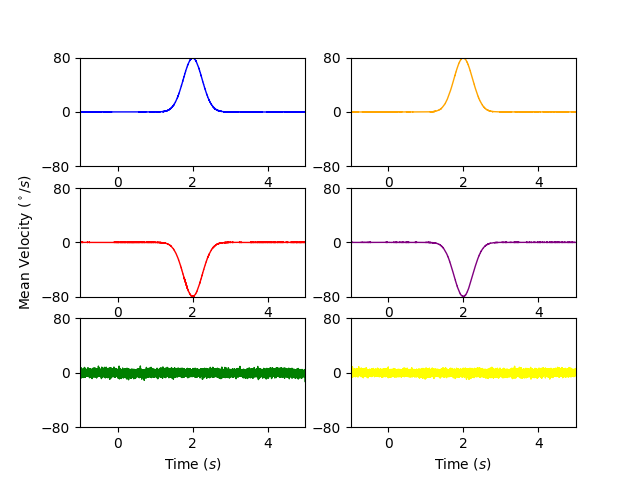

In [34]:
plots(3, 2,
      lambda ax: plotVelocity(MeanRotation['first']['CW'], 'blue', ax, xlabel=False, ylabel=False),
      lambda ax: plotVelocity(MeanRotation['first']['CCW'], 'red', ax, xlabel=False, ylabel=True),
      lambda ax: plotVelocity(MeanRotation['first']['NotResponding'], 'green', ax, xlabel=True, ylabel=False),
      lambda ax: plotVelocity(MeanRotation['second']['CW'], 'orange', ax, xlabel=False, ylabel=False),
      lambda ax: plotVelocity(MeanRotation['second']['CCW'], 'purple', ax, xlabel=False, ylabel=False),
      lambda ax: plotVelocity(MeanRotation['second']['NotResponding'], 'yellow', ax, xlabel=True, ylabel=False)
     )

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Raster plots</strong></span>

In [35]:
Raster_saving_folder = os.path.join(saving_folder, 'Raster', exp_id)
os.makedirs(Raster_saving_folder, exist_ok=True)

for condition in ['first','second']:
      for direction in ['CW','CCW']:
            plots(int(len(SpikeTimes[condition][direction])/4), 4,
                  *[(lambda neuron: lambda ax: plotRaster(SpikeTimes[condition][direction][neuron], 'k', ax, xlabel=False, ylabel=False))(neuron) for neuron in range(len(SpikeTimes[condition][direction]))],
                  suptitle=f"{condition} condition {direction} {exp_id}",
                  save=Saving_boolean,
                  filename=os.path.join(Raster_saving_folder, f"Raster_{exp_id}_{condition}_condition_{direction}.pdf")
            )
            print('\n')

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>PSTH</strong></span>

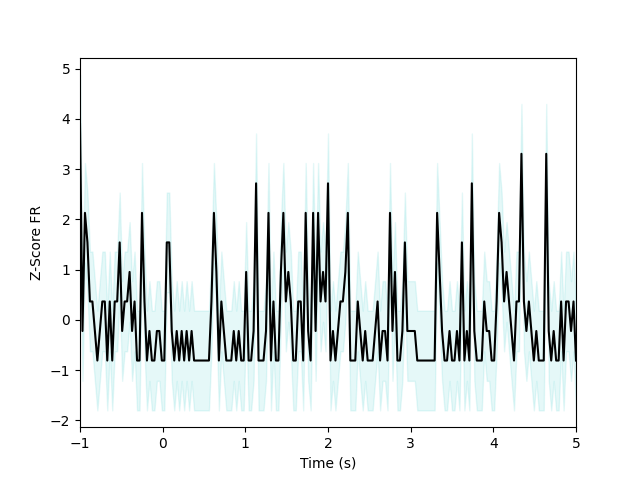

In [36]:
plotPSTH(SpikeTimes['first']['CW'][0],binResolution=0.03)

In [37]:
PSTH_saving_folder = os.path.join(saving_folder, 'PSTH', exp_id)
os.makedirs(PSTH_saving_folder, exist_ok=True)

for condition in ['first','second']:
      for direction in ['CW','CCW']:
            plots(int(len(SpikeTimes[condition][direction])/4), 4,
                  *[(lambda neuron: lambda ax: plotPSTH(SpikeTimes[condition][direction][neuron],'k', 'k', ax=ax,xlabel=False,ylabel=False))(neuron) for neuron in range(len(SpikeTimes[condition][direction]))],
                  suptitle=f"{condition} condition {direction} {exp_id}",
                  save=True,
                  filename=os.path.join(PSTH_saving_folder, f"PSTH_{exp_id}_{condition}_condition_{direction}.pdf")
            )
            print('\n')

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Figure 1</strong></span>

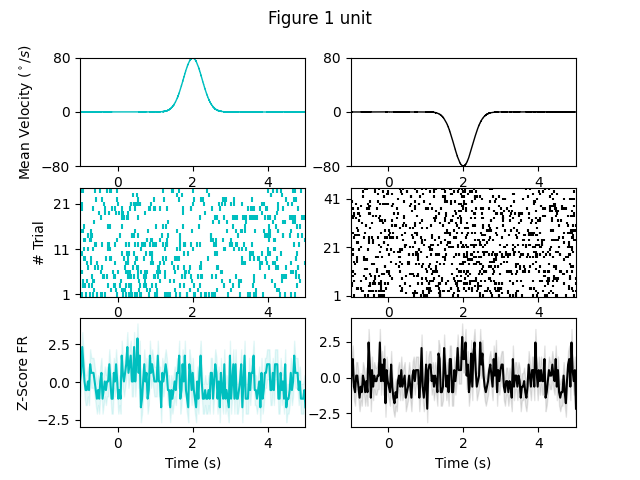

In [38]:
unit = 16

figure1(unit)

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>PSTH Heatmap</strong></span>

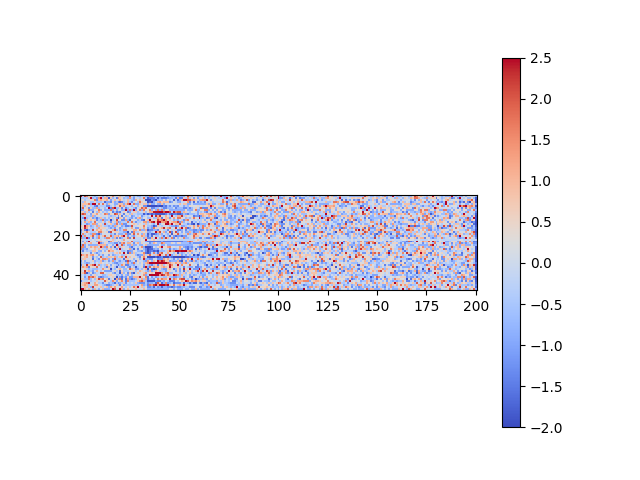

In [39]:
Zmaxiscore = [[] for _ in range(len(SpikeTimes['first']['CW']))]

for unit in range(len(SpikeTimes['first']['CW'])):
    StudiedSpikeTimes = SpikeTimes['first']['CW'][unit]

    color='k'
    shadedcolor='k'
    ylabel=True
    xlabel=True

    local_trial_number = len(StudiedSpikeTimes)

    binResolution=0.03

    spike_number_per_trial = [[] for _ in range(local_trial_number)]
    edges = []
    unitary_firing_rate = [[] for _ in range(local_trial_number)]

    for trial in range(local_trial_number):
        spike_number_per_trial[trial], edges = np.histogram(StudiedSpikeTimes[trial], bins=np.arange(-timeBef, timeAft + binResolution, binResolution))

    frequency_per_trial = [[spike_number_per_trial[trial][bin]/binResolution for bin in range(len(edges)-1)] for trial in range(local_trial_number)]
    mean_frequency = [np.mean([frequency_per_trial[trial][bin] for trial in range(local_trial_number)]) for bin in range(len(edges)-1)]

    Zscore = (mean_frequency - np.mean(mean_frequency)) / np.std(mean_frequency)
    Zunitary = (frequency_per_trial - np.mean(mean_frequency)) / np.std(mean_frequency)
    SEM = np.std(Zunitary)/np.sqrt(len(Zunitary))

    # # plt.figure(figsize=(15,6))
    # plt.plot(edges[:-1], Zscore, color=color)
    # plt.fill_between(edges[:-1], Zscore-SEM, Zscore+SEM, alpha=0.1, color=shadedcolor)
    # plt.xlim(-timeBef,timeAft)
    # if ylabel:
    #     plt.ylabel('PSTH')
    # if xlabel:
    #     plt.xlabel('Time (s)')
    # plt.show()

    Zmaxiscore[unit] = Zscore



# del Zmaxiscore[22]


# # Créer des données aléatoires pour le heatmap (une matrice 10x10)
# data = np.random.rand(10, 100)

# Afficher le heatmap
plt.imshow(Zmaxiscore, cmap='coolwarm', interpolation='nearest', vmin=-2,vmax=2.5)
plt.colorbar()  # Ajouter une barre de couleur pour référence
# plt.xticks(duration)
plt.show()

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Statistics</strong></span>

### <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Spike counting</strong></span>

In [40]:
windowDurArray = np.where(abs(MeanRotation['first']['CW'])>40)
windowDur = [windowDurArray[0][0],windowDurArray[0][-1]]
windowLen = len(windowDurArray[0])
windowBef = [1*f, 1*f+windowLen]

numberBef = {
    'first': {
        'CW': [[] for _ in range(len(SpikeTimes['first']['CW']))],
        'CCW': [[] for _ in range(len(SpikeTimes['first']['CCW']))],
        'NotResponding': [[] for _ in range(len(SpikeTimes['first']['NotResponding']))]
    },
    'second': {
        'CW': [[] for _ in range(len(SpikeTimes['second']['CW']))],
        'CCW': [[] for _ in range(len(SpikeTimes['second']['CCW']))],
        'NotResponding': [[] for _ in range(len(SpikeTimes['second']['NotResponding']))]
    }
}
numberDur = {
    'first': {
        'CW': [[] for _ in range(len(SpikeTimes['first']['CW']))],
        'CCW': [[] for _ in range(len(SpikeTimes['first']['CCW']))],
        'NotResponding': [[] for _ in range(len(SpikeTimes['first']['NotResponding']))]
    },
    'second': {
        'CW': [[] for _ in range(len(SpikeTimes['second']['CW']))],
        'CCW': [[] for _ in range(len(SpikeTimes['second']['CCW']))],
        'NotResponding': [[] for _ in range(len(SpikeTimes['second']['NotResponding']))]
    }
}
diffBefDur = {
    'first': {
        'CW': [[] for _ in range(len(SpikeTimes['first']['CW']))],
        'CCW': [[] for _ in range(len(SpikeTimes['first']['CCW']))],
        'NotResponding': [[] for _ in range(len(SpikeTimes['first']['NotResponding']))]
    },
    'second': {
        'CW': [[] for _ in range(len(SpikeTimes['second']['CW']))],
        'CCW': [[] for _ in range(len(SpikeTimes['second']['CCW']))],
        'NotResponding': [[] for _ in range(len(SpikeTimes['second']['NotResponding']))]
    }
}
sumBefDur = {
    'first': {
        'CW': [[] for _ in range(len(SpikeTimes['first']['CW']))],
        'CCW': [[] for _ in range(len(SpikeTimes['first']['CCW']))],
        'NotResponding': [[] for _ in range(len(SpikeTimes['first']['NotResponding']))]
    },
    'second': {
        'CW': [[] for _ in range(len(SpikeTimes['second']['CW']))],
        'CCW': [[] for _ in range(len(SpikeTimes['second']['CCW']))],
        'NotResponding': [[] for _ in range(len(SpikeTimes['second']['NotResponding']))]
    }
}
vMI = {
    'first': {
        'CW': [[] for _ in range(len(SpikeTimes['first']['CW']))],
        'CCW': [[] for _ in range(len(SpikeTimes['first']['CCW']))],
        'NotResponding': [[] for _ in range(len(SpikeTimes['first']['NotResponding']))]
    },
    'second': {
        'CW': [[] for _ in range(len(SpikeTimes['second']['CW']))],
        'CCW': [[] for _ in range(len(SpikeTimes['second']['CCW']))],
        'NotResponding': [[] for _ in range(len(SpikeTimes['second']['NotResponding']))]
    }
}


for condition in SpikeTimes:
    for direction in SpikeTimes[condition]:
        for unit in range(len(SpikeTimes[condition][direction])):
            for trial in range(len(SpikeTimes[condition][direction][unit])):

                lowerBef = SpikeTimes[condition][direction][unit][trial] > duration[windowBef[0]]
                upperBef = SpikeTimes[condition][direction][unit][trial] < duration[windowBef[1]]
                lowerDur = SpikeTimes[condition][direction][unit][trial] > duration[windowDur[0]]
                upperDur = SpikeTimes[condition][direction][unit][trial] < duration[windowDur[1]]

                numberBef[condition][direction][unit].append(np.count_nonzero(lowerBef & upperBef))
                numberDur[condition][direction][unit].append(np.count_nonzero(lowerDur & upperDur))

            diffBefDur[condition][direction][unit] = np.mean(numberDur[condition][direction][unit]) - np.mean(numberBef[condition][direction][unit])
            sumBefDur[condition][direction][unit] = np.mean(numberDur[condition][direction][unit]) + np.mean(numberBef[condition][direction][unit])
            vMI[condition][direction][unit] = diffBefDur[condition][direction][unit] / sumBefDur[condition][direction][unit]

### <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Paired Wilcoxon Test</strong></span>

In [41]:
statistics = {
    'first': {
        'CW': [[] for _ in range(len(SpikeTimes['first']['CW']))],
        'CCW': [[] for _ in range(len(SpikeTimes['first']['CCW']))],
        'NotResponding': [[] for _ in range(len(SpikeTimes['first']['NotResponding']))]
    },
    'second': {
        'CW': [[] for _ in range(len(SpikeTimes['second']['CW']))],
        'CCW': [[] for _ in range(len(SpikeTimes['second']['CCW']))],
        'NotResponding': [[] for _ in range(len(SpikeTimes['second']['NotResponding']))]
    }
}

p_values = {
    'first': {
        'CW': [[] for _ in range(len(SpikeTimes['first']['CW']))],
        'CCW': [[] for _ in range(len(SpikeTimes['first']['CCW']))],
        'NotResponding': [[] for _ in range(len(SpikeTimes['first']['NotResponding']))]
    },
    'second': {
        'CW': [[] for _ in range(len(SpikeTimes['second']['CW']))],
        'CCW': [[] for _ in range(len(SpikeTimes['second']['CCW']))],
        'NotResponding': [[] for _ in range(len(SpikeTimes['second']['NotResponding']))]
    }
}



for condition in SpikeTimes:
    for direction in SpikeTimes[condition]:
        for unit in range(len(SpikeTimes[condition][direction])):
            results = wilcoxon(numberBef[condition][direction][unit], numberDur[condition][direction][unit])
            statistics[condition][direction][unit].append(results[0])
            p_values[condition][direction][unit].append(results[1])


C:\Users\gbouvier\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


In [42]:
print(numberBef['first']['CW'][0])

print(numberDur['first']['CW'][0])

print(statistics['first']['CW'][0])

print(p_values['first']['CW'][0])

[0, 2, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0]
[0, 0, 3, 4, 0, 0, 4, 0, 0, 0, 8, 0, 0, 0, 0, 2, 4, 0, 2, 2, 8, 7, 0, 0]
[18.0]
[0.053591770531342]


### <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Determination of significant units by condition & rotation</strong></span>

In [43]:
p_value_threshold = 0.05

significance = {
    'first': {
        'CW': [],
        'CCW': [],
        'NotResponding': []
    },
    'second': {
        'CW': [],
        'CCW': [],
        'NotResponding': []
    }
}

for condition in SpikeTimes:
    for direction in SpikeTimes[condition]:
        significance[condition][direction] = np.where([p_values[condition][direction][neuron][0]<p_value_threshold for neuron in range(Nclust)])

### <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Visual Overview Of Spike Numbers Before & During</strong></span>

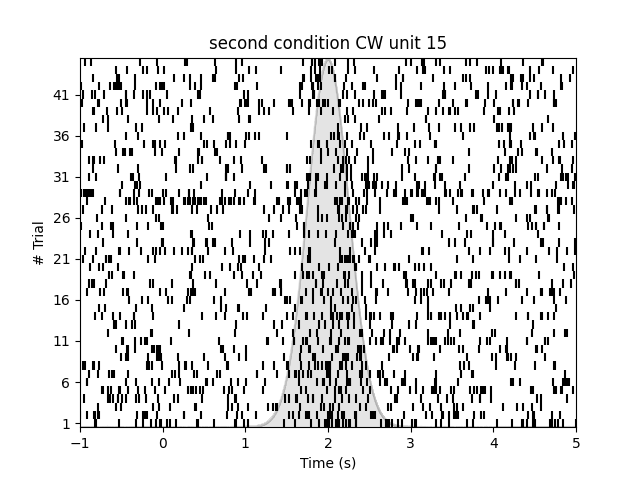

Number of spikes before rotation : [5, 3, 3, 3, 8, 4, 5, 5, 2, 0, 1, 1, 1, 1, 1, 4, 5, 2, 4, 1, 3, 7, 5, 2, 2, 1, 5, 14, 6, 1, 2, 3, 5, 3, 3, 3, 2, 3, 4, 2, 3, 4, 4, 1, 2]
Number of spikes during rotation : [14, 10, 5, 7, 6, 11, 8, 12, 7, 5, 9, 4, 5, 11, 3, 6, 8, 6, 8, 3, 8, 4, 1, 7, 4, 6, 5, 6, 5, 7, 10, 6, 7, 4, 7, 5, 1, 2, 4, 9, 5, 7, 7, 6, 8]
True


In [44]:
condition = 'second'
direction = 'CW'
unit = 15

plotRaster(SpikeTimes[condition][direction][unit], title=f"{condition} condition {direction} unit {unit}",plotvelocity=True)

print(f'Number of spikes before rotation : {numberBef[condition][direction][unit]}')
print(f'Number of spikes during rotation : {numberDur[condition][direction][unit]}')
print(len(numberBef[condition][direction][unit])==len(numberDur[condition][direction][unit]))

In [45]:
duration[windowBef[1]]

0.5864333333331586

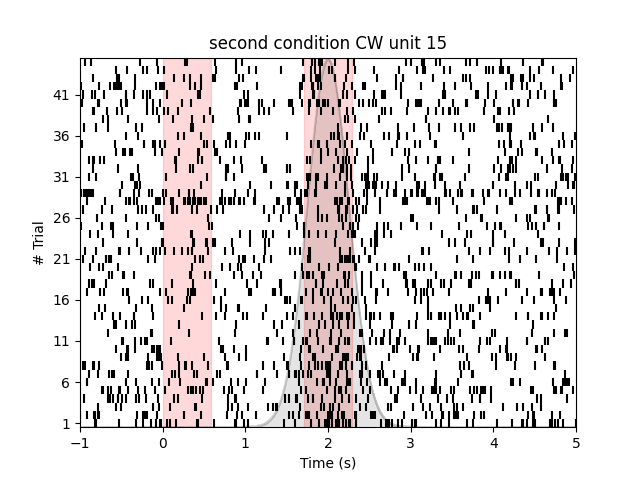

Number of spikes before rotation : [5, 3, 3, 3, 8, 4, 5, 5, 2, 0, 1, 1, 1, 1, 1, 4, 5, 2, 4, 1, 3, 7, 5, 2, 2, 1, 5, 14, 6, 1, 2, 3, 5, 3, 3, 3, 2, 3, 4, 2, 3, 4, 4, 1, 2]
Number of spikes during rotation : [14, 10, 5, 7, 6, 11, 8, 12, 7, 5, 9, 4, 5, 11, 3, 6, 8, 6, 8, 3, 8, 4, 1, 7, 4, 6, 5, 6, 5, 7, 10, 6, 7, 4, 7, 5, 1, 2, 4, 9, 5, 7, 7, 6, 8]
True


In [46]:
condition = 'second'
direction = 'CW'
unit = 15

plotRaster(SpikeTimes[condition][direction][unit], title=f"{condition} condition {direction} unit {unit}",plotvelocity=True,#
           extra=lambda: (#
               plt.axvspan(duration[windowBef[0]], duration[windowBef[1]], color='red', alpha=0.15),#
               plt.axvspan(duration[windowDur[0]], duration[windowDur[1]], color='red', alpha=0.15)#
               )#
               )

print(f'Number of spikes before rotation : {numberBef[condition][direction][unit]}')
print(f'Number of spikes during rotation : {numberDur[condition][direction][unit]}')
print(len(numberBef[condition][direction][unit])==len(numberDur[condition][direction][unit]))

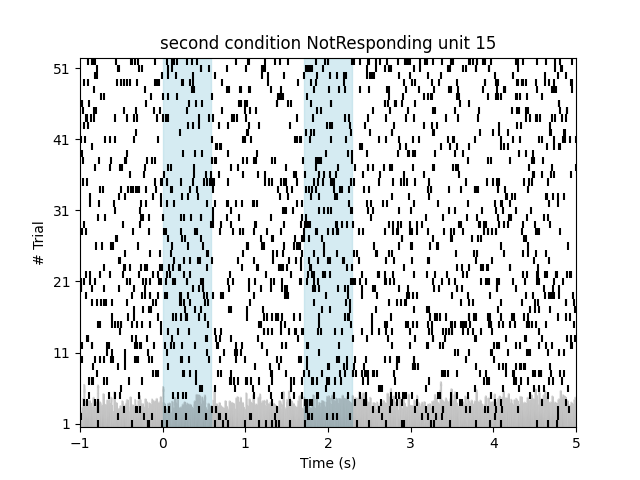

(array([35], dtype=int64),)
[1, 3, 3, 0, 4, 2, 1, 4, 1, 4, 2, 5, 3, 3, 1, 8, 3, 6, 7, 4, 7, 4, 5, 5, 3, 3, 4, 5, 0, 6, 0, 3, 3, 4, 7, 3, 3, 0, 3, 0, 0, 1, 3, 5, 1, 3, 3, 2, 4, 3, 5, 7]
[1, 7, 2, 5, 4, 1, 7, 5, 5, 4, 1, 3, 0, 4, 2, 4, 3, 3, 2, 6, 4, 6, 4, 6, 3, 1, 2, 9, 8, 1, 5, 1, 4, 8, 7, 5, 2, 5, 3, 0, 3, 4, 4, 3, 2, 3, 1, 4, 3, 6, 6, 5]


In [47]:
condition = 'second'
direction = 'NotResponding'
unit = 15

plotRaster(SpikeTimes[condition][direction][unit],title=f"{condition} condition {direction} unit {unit}",
            extra=lambda: (
                plt.axvspan(duration[windowBef[0]], duration[windowBef[1]], color='lightblue', alpha=0.5),
                plt.axvspan(duration[windowDur[0]], duration[windowDur[1]], color='lightblue', alpha=0.5)
            ),plotvelocity=True)

print(significance[condition][direction])

print(numberBef[condition][direction][unit])
print(numberDur[condition][direction][unit])

### <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Resuming Modulations</strong></span>

In [48]:
modulation = {
    'first': [
        {
            'selectivity': [],
            'type': []
        } for _ in range(Nclust)],
    'second': [
        {
            'selectivity': [],
            'type': []
        } for _ in range(Nclust)]
}



for unit in range(Nclust):
    for condition in significance:

        both = (unit in significance[condition]['CW'][0]) and (unit in significance[condition]['CCW'][0])
        CW = unit in significance[condition]['CW'][0]
        CCW = unit in significance[condition]['CCW'][0]



        if not (both or CW or CCW):
            modulation[condition][unit]['selectivity'] = 'unmodulated'
            modulation[condition][unit]['type'] = '0'
        else:
            if both:
                modulation[condition][unit]['selectivity'] = 'both'
                if (diffBefDur[condition]['CW'][unit] >= 0) and (diffBefDur[condition]['CCW'][unit] >= 0):
                    modulation[condition][unit]['type'] = '+/+'
                elif (diffBefDur[condition]['CW'][unit] < 0) and (diffBefDur[condition]['CCW'][unit] < 0):
                    modulation[condition][unit]['type'] = '-/-'
                elif (diffBefDur[condition]['CW'][unit] < 0) and (diffBefDur[condition]['CCW'][unit] >= 0):
                    modulation[condition][unit]['type'] = '-/+'
                elif (diffBefDur[condition]['CW'][unit] >= 0) and (diffBefDur[condition]['CCW'][unit] < 0):
                    modulation[condition][unit]['type'] = '+/-'
            elif CW:
                modulation[condition][unit]['selectivity'] = 'CW'
                modulation[condition][unit]['type'] = '+' if diffBefDur[condition]['CW'][unit] >= 0 else '-'
            elif CCW:
                modulation[condition][unit]['selectivity'] = 'CCW'
                modulation[condition][unit]['type'] = '+' if diffBefDur[condition]['CCW'][unit] >= 0 else '-'


# Convert lists -> NumPy
for condition in modulation:
    modulation[condition] = np.array(modulation[condition])

The both +/+ modulated neurons are [ 4  6  7  8 12 13 14 15 16 18 19 23 26 27 28 30 33 34 35 37 40 43]


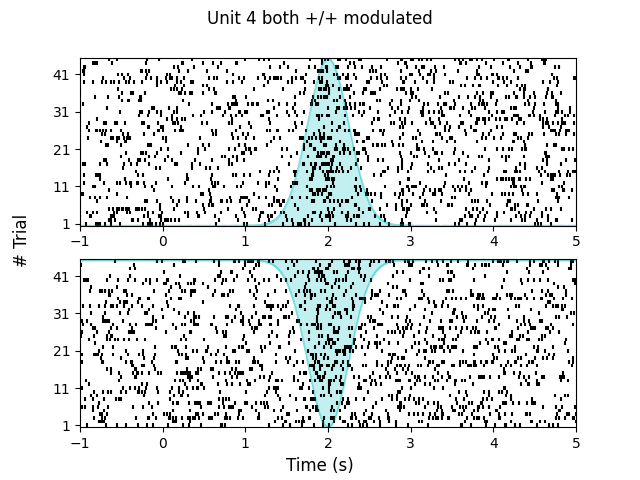

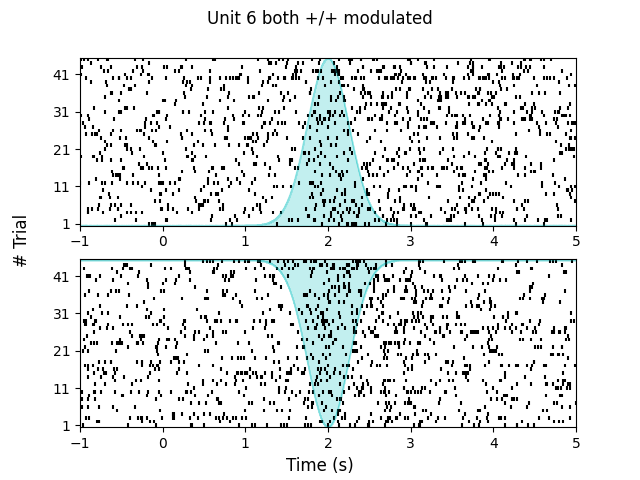

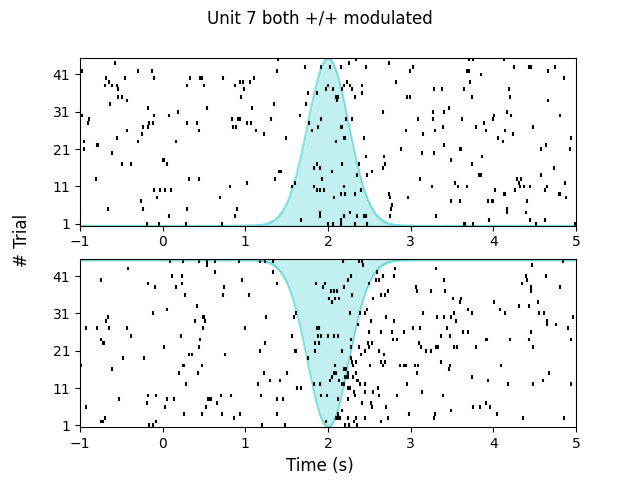

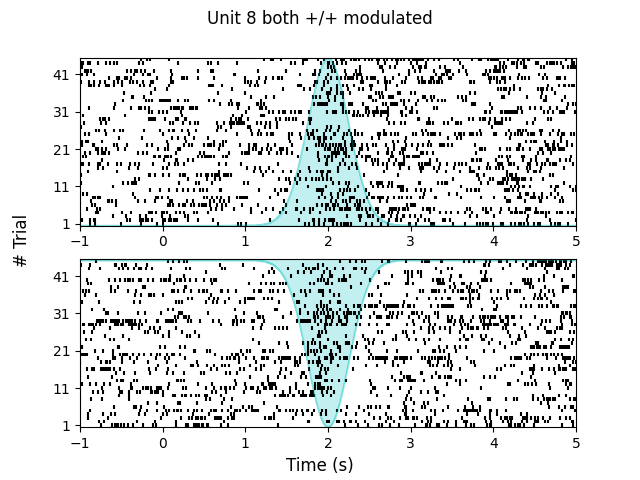

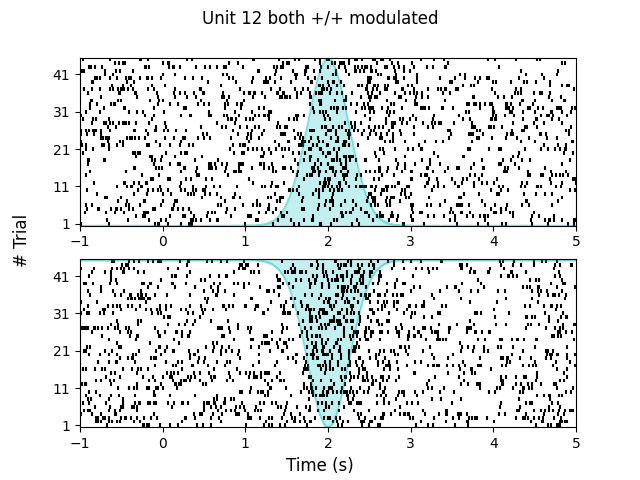

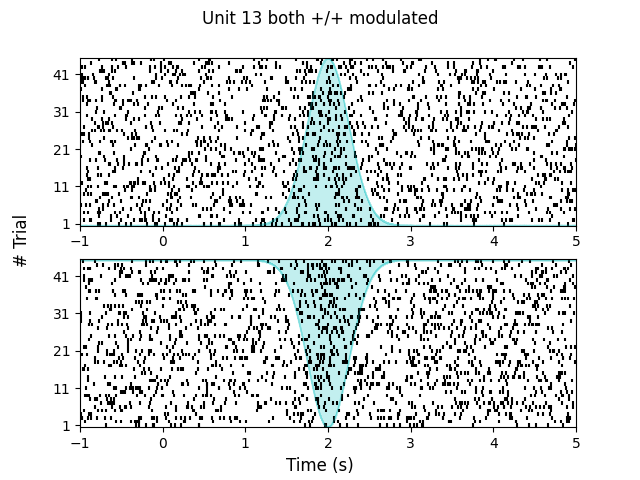

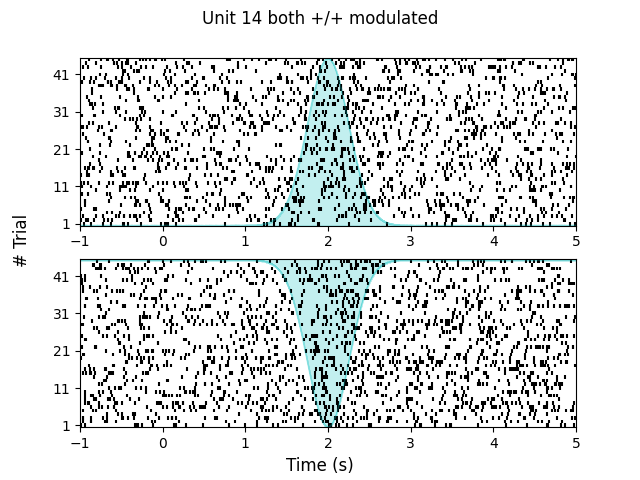

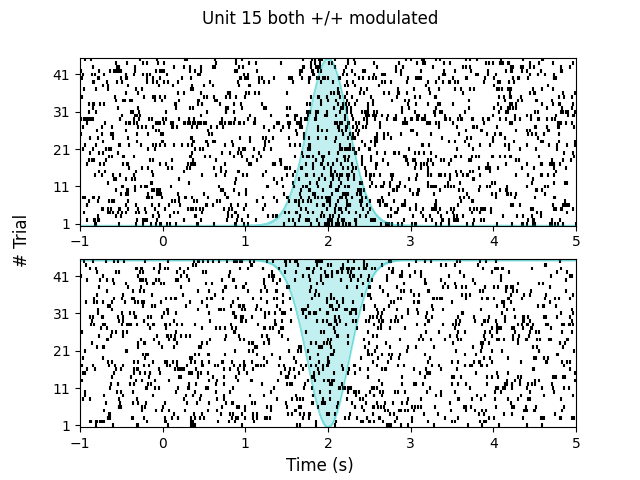

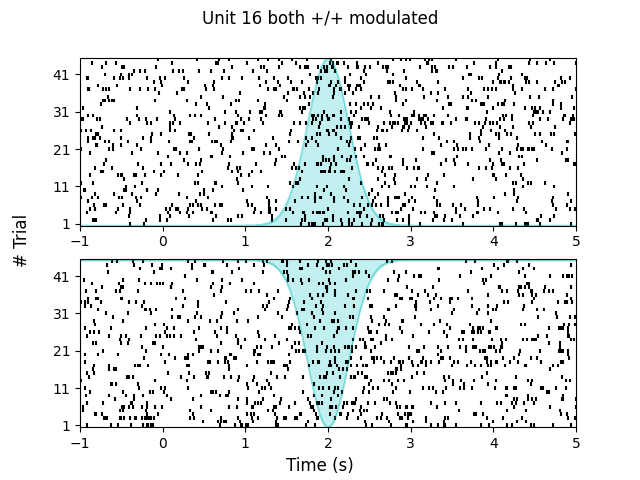

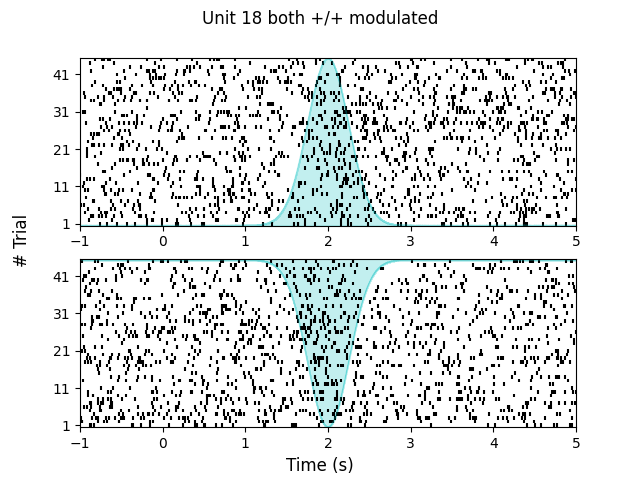

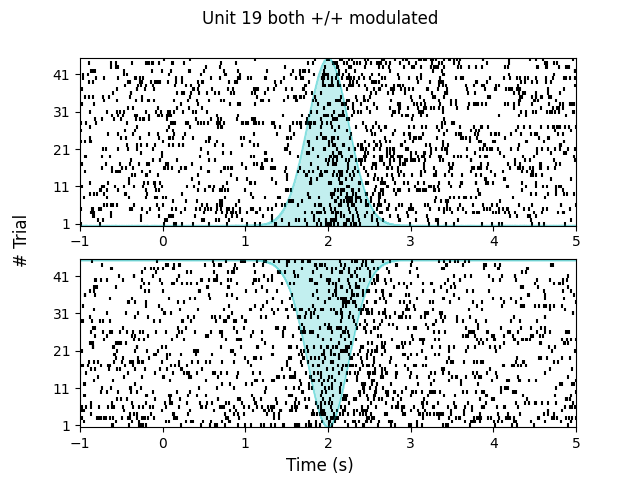

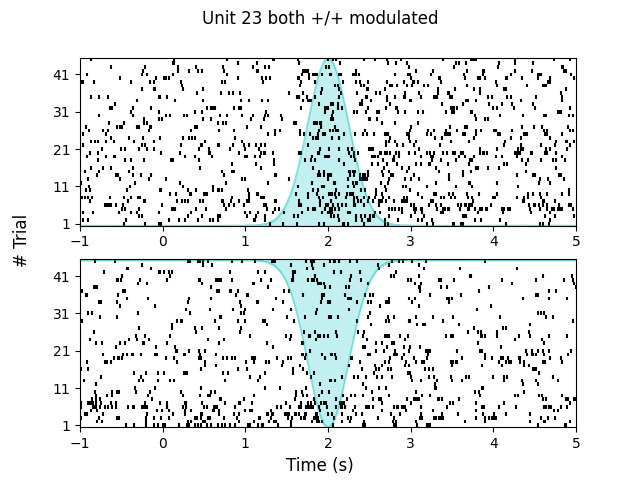

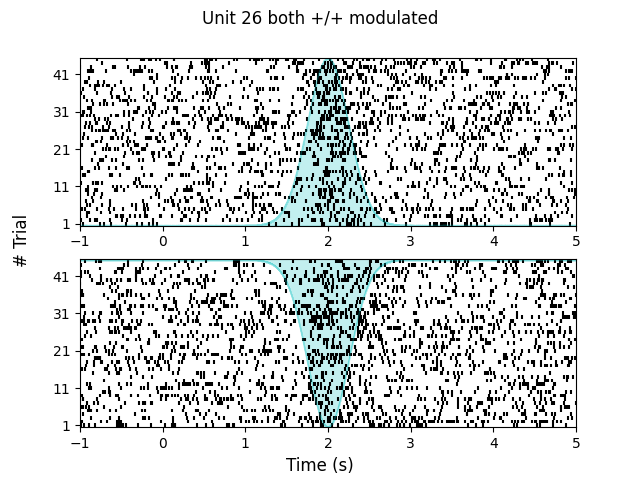

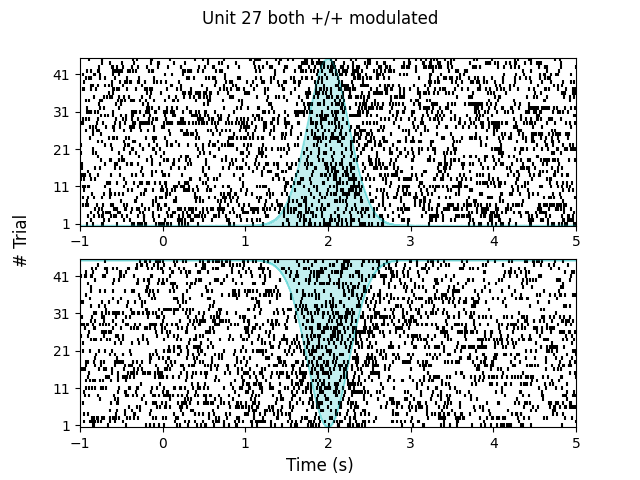

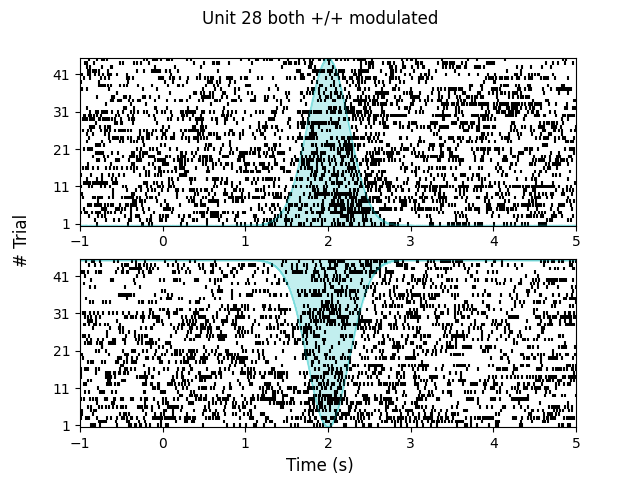

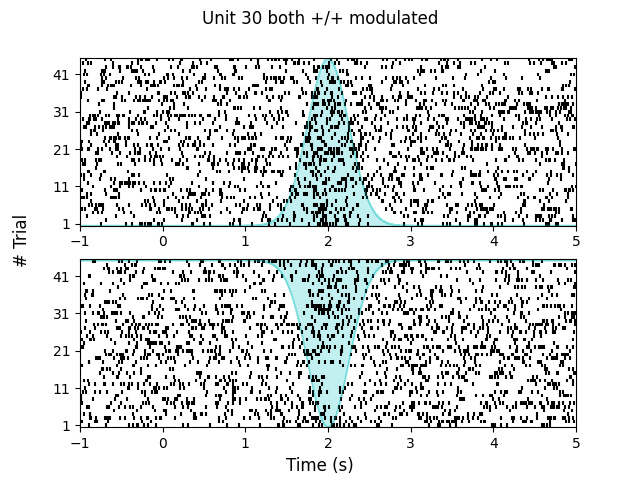

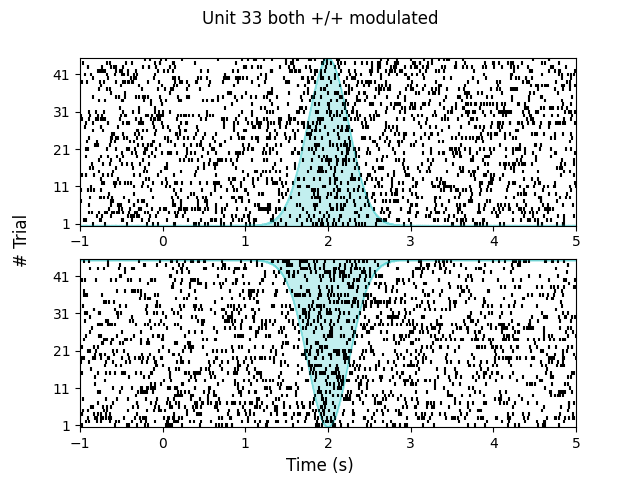

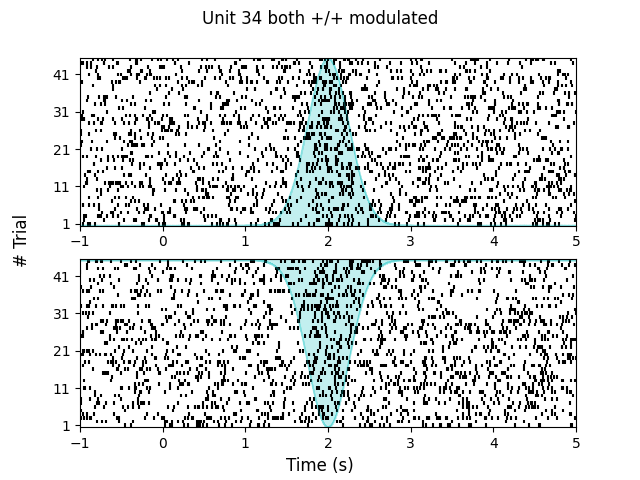

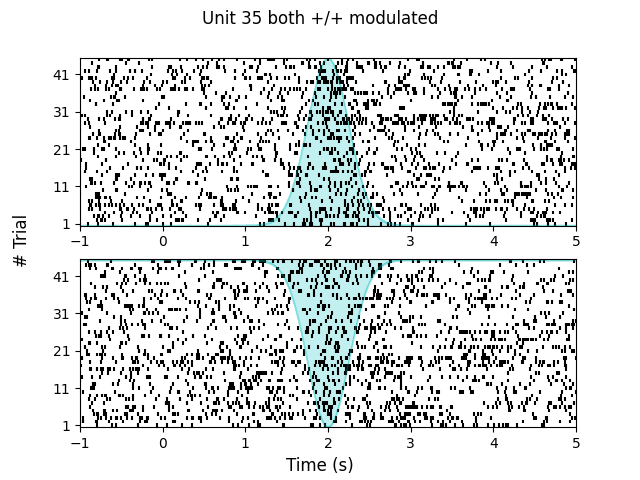

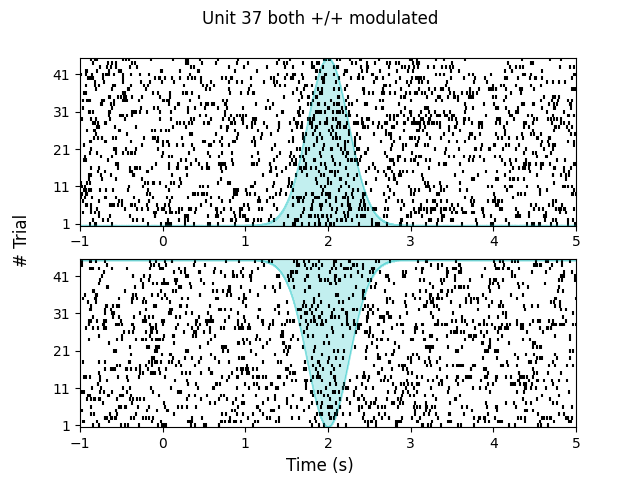

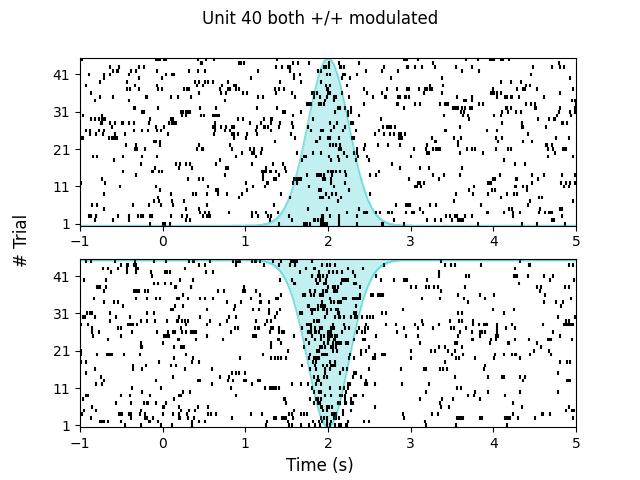

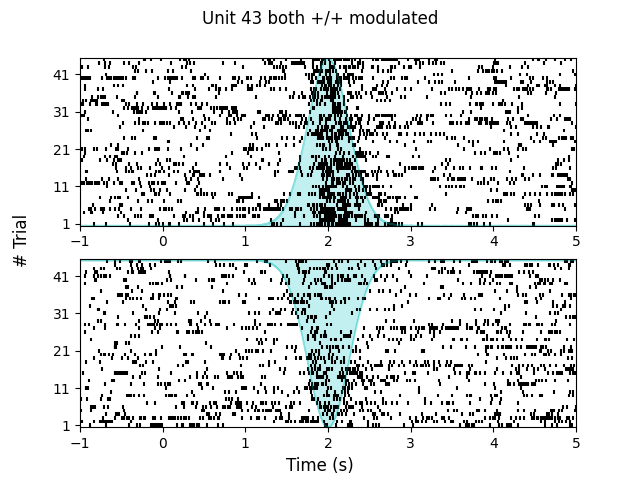

In [49]:
seeModulation('second', 'both +/+', velocityalpha=0.3, velocitycolor='c')

### <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Showing Numerical Results</strong></span>

In [50]:
print(f"Unit CW of first condition, significant modulation : {significance['first']['CW'][0]}\n")

print(f"Unit CCW of first condition, significant modulation : {significance['first']['CCW'][0]}\n")

print(f"Unit CW of second condition, significant modulation : {significance['second']['CW'][0]}\n")

print(f"Unit CCW of second condition, significant modulation : {significance['second']['CCW'][0]}")


Unit CW of first condition, significant modulation : [ 1  2  5  6  8  9 10 13 14 15 16 17 20 22 23 25 31 34 40 42 44 45 46 47]

Unit CCW of first condition, significant modulation : [ 1  5  6  8  9 13 14 15 17 19 20 22 23 25 26 27 28 30 31 34 40 41 42 45
 46 47]

Unit CW of second condition, significant modulation : [ 0  1  2  4  6  7  8 10 11 12 13 14 15 16 17 18 19 23 24 25 26 27 28 30
 31 32 33 34 35 37 39 40 43 46]

Unit CCW of second condition, significant modulation : [ 2  4  6  7  8 12 13 14 15 16 17 18 19 20 21 23 26 27 28 30 31 33 34 35
 37 40 42 43 46]


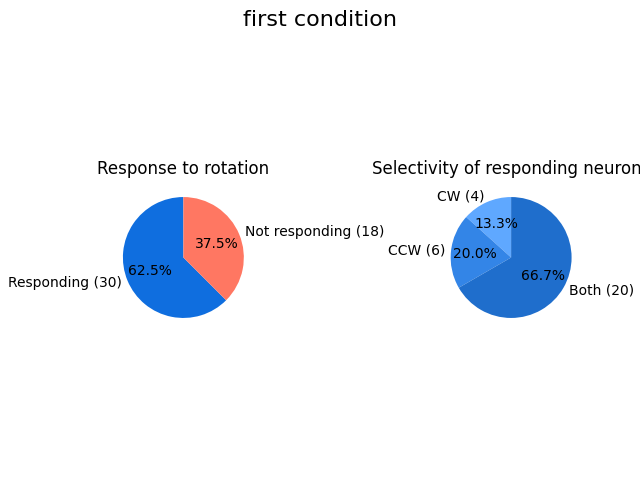

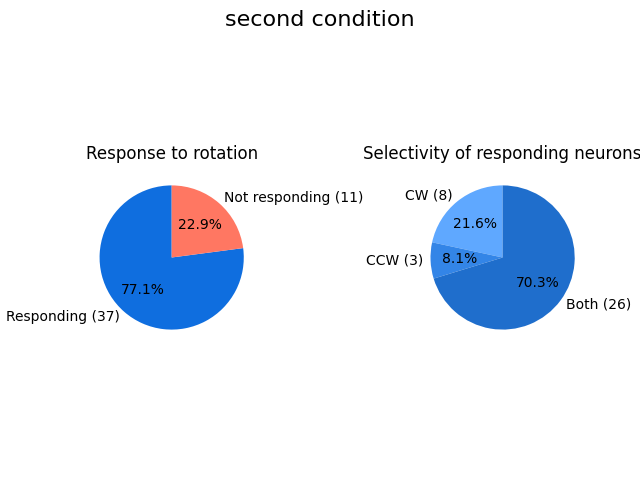

In [51]:
for condition in ['first','second']:
    CWmod = np.count_nonzero([modulation[condition][neuron]['selectivity'] == 'CW' for neuron in range(Nclust)])
    CCWmod = np.count_nonzero([modulation[condition][neuron]['selectivity'] == 'CCW' for neuron in range(Nclust)])
    BOTHmod = np.count_nonzero([modulation[condition][neuron]['selectivity'] == 'both' for neuron in range(Nclust)])
    resp_units = CWmod + CCWmod + BOTHmod
    nonresp_units = Nclust - resp_units


    labels = ['Responding', 'Not responding']
    valeurs = [resp_units, nonresp_units]

    plt.rcParams.update({
        "text.usetex": False,
        # "font.family": "Helvetica"
    })

    plt.subplot(1, 2, 1)
    plt.pie(valeurs, labels=["{} ({})".format(label, valeur) for label, valeur in zip(labels, valeurs)], autopct='%1.1f%%', startangle=90, colors=['#0F6EDF', '#FF7762'])
    plt.title('Response to rotation')



    labels_selectivite = ['CW', 'CCW', 'Both']
    valeurs_selectivite = [CWmod, CCWmod, BOTHmod]

    print("\n")
    plt.subplot(1, 2, 2)
    plt.pie(valeurs_selectivite, labels=["{} ({})".format(label, valeur) for label, valeur in zip(labels_selectivite, valeurs_selectivite)], autopct='%1.1f%%', startangle=90, colors=['#5FA8FF', '#3385E7', '#1F6ECC'])
    plt.title('Selectivity of responding neurons')

    # plt.suptitle(r"\bf\fbox{{condition} condition}", fontsize=16)
    plt.suptitle(f"{condition} condition", fontsize=16)

    plt.tight_layout()

    if Saving_boolean:
        os.makedirs(os.path.join(saving_folder, 'Distribution'), exist_ok=True)
        plt.savefig(os.path.join(saving_folder, 'Distribution', f"Distribution_{exp_id}_{condition}_condition.png"))
        plt.close()
    else:
        plt.show()


# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Saving Variables</strong></span>

In [52]:
if Saving_boolean:
    data = {
        'informative_data': {
            'index_animal': index_animal,
            'exp_id': exp_id,
            'timeBef': timeBef,
            'timeAft': timeAft,
            'refValue': refValue,
            'din': din,
            'time': time,
            'chanSpace': chanSpace,
            'rotationSpeed': rotationSpeed,
            'ProbeType': ProbeType,
            'f': f,
            'ML_pos': ML_pos,
            'AP_pos': AP_pos
            },
        'Spiking_times': {
            'AllSpikeTimesMUA': AllSpikeTimesMUA,
            'SpikeTimesMUA': SpikeTimesMUA,
            'Ntrial': Ntrial,
            'thresholdTrial': thresholdTrial,
            'AllSpikeTimes': AllSpikeTimes,
            'SpikeTimes': SpikeTimes,
        },
        'Rotation_data': {
            'ref': ref,
            'dref': dref,
            'pic_position': pic_position,
            'RotationWise': RotationWise,
            'Rotation': Rotation,
            'MeanRotation': MeanRotation,
            'duration': duration,
            'table_velocity': table_velocity
        },
        'SUA_data': {
            'c_class': c_class,
            'Nclust': Nclust
        },
        'MUA_data': {
            'm_class': m_class,
            'm_class_tet': m_class_tet,
            'Nclust_mua': Nclust_mua,
            'Ntet': Ntet,
            'allBasem': allBasem,
            'PkDepthUnit': PkDepthUnit,
            'mapp': mapp,
            'ArgallLayers': ArgallLayers,
            'DepthTetrode': DepthTetrode
        },
        'Statistics_data': {
            'windowBef': windowBef,
            'windowDur': windowDur,
            'numberBef': numberBef,
            'numberDur': numberDur,
            'diffBefDur': diffBefDur,
            'sumBefDur': sumBefDur,
            'statistics': statistics,
            'p_values': p_values,
            'significance': significance,
            'modulation': modulation,
            'vMI':vMI
        }
    }



    data_saving_folder = os.path.join(saving_folder, 'Data', exp_id)

    if not os.path.exists(data_saving_folder):
        os.makedirs(data_saving_folder)

    # from tqdm import tqdm

    # with tqdm(total=100) as pbar:
    #     jd.save(data, os.path.join(saving_folder, exp_id+"_data.json"), progress=lambda *args: pbar.update(100))

    jd.save(data, os.path.join(data_saving_folder, exp_id+"_data.json"))

In [53]:
# import os
# saving_folder = os.path.join('/Users/abdussamed.yazici/BOUVIER', 'Data', 'animal21_a53d1s1')
# os.makedirs(saving_folder, exist_ok=True)
# jd.save(data, os.path.join(saving_folder, exp_id+'_data.json'))
